# Explore latent space features
We want to know if our VAE model is capturing our signal

Identify high weight (HW) genes for each latent space feature (node)
Determine if genes in group A and B are found within these highly weighted genes

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


randomState = 123
from numpy.random import seed
seed(randomState)

In [3]:
# Load arguments
analysis_name = "sim_AB_2775_300_v2"
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "VAE_weight_matrix.txt")
A_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetA.txt")
B_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetB.txt")

#HW_file = os.path.join(os.path.dirname(os.getcwd()), "output", analysis_name, "HW_genes.txt")

In [4]:
# Read in data
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

weight = pd.read_table(data_file, header=0, index_col=0).T
weight.head(5)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
PA0001,-0.109896,-0.046397,-0.074332,-0.147623,-0.001468,-0.144918,-0.082134,-0.025183,-0.032311,-0.066211,...,-0.069226,-0.100556,0.027667,-0.103827,0.012406,-0.080507,-0.081776,-0.119806,-0.058431,-0.052509
PA0002,-0.246034,-0.291839,-0.312141,-0.160919,-0.081482,0.099776,-0.260427,-0.091375,-0.048770,-0.187572,...,-0.381651,-0.206640,-0.150470,-0.108064,-0.068341,-0.169337,-0.291553,-0.219857,-0.213785,-0.347230
PA0003,-0.034835,-0.178960,-0.045592,-0.132694,0.053346,-0.045186,-0.110322,-0.075096,-0.068044,-0.003200,...,-0.152220,-0.220926,-0.048476,-0.119541,-0.185043,-0.079093,-0.124860,-0.130549,-0.041711,-0.109421
PA0004,-0.041675,0.076071,-0.029738,-0.071658,-0.020806,-0.025592,-0.053239,-0.095967,-0.014828,-0.147332,...,0.019170,-0.072496,-0.040608,0.010228,0.003787,-0.054657,-0.021753,-0.045891,-0.085524,-0.100793
PA0005,-0.011299,-0.013832,0.064513,0.027427,0.024888,0.045149,0.021256,0.028361,-0.035507,0.060045,...,0.010586,-0.029618,0.017413,-0.061491,-0.045682,0.008379,0.074103,0.058450,-0.052197,-0.008725


In [5]:
# Plot the distribution of gene weights per latent feature
#num_features = weight.shape[1]

#f, axes = plt.subplots(num_features, 1, sharex=True)
#for i, ax in zip(weight.columns, axes.flat):
#    sns.distplot(weight[i] , color="skyblue", rug=False, kde=False, ax=ax)
    
#f.set_size_inches(15, 15)

In [6]:
# Calculate mean per node ("signature" or "feature")
means = weight.mean(axis=0)

# Calculate 2 standard deviations per node ("signature" or "feature")
stds = weight.std(axis=0)
two_stds = 2*stds

In [7]:
# Get high positive and negative weight genes per node ("signature" or "feature") -- HW_df
# Record metadata per latent feature in a table -- HW_metadata_df
# Record distance between gene set weight and 
HW_df = pd.DataFrame()
HW_metadata_df = pd.DataFrame()

num_nodes = len(means)

for i in range(num_nodes):
    node_mean = means.iloc[i]
    node_std = stds.iloc[i] 
    
    pos_threshold = node_mean + two_stds.iloc[i]
    neg_threshold = node_mean - two_stds.iloc[i]
    
    hw_pos_genes = weight[weight[i+1] > pos_threshold].index
    hw_neg_genes = weight[weight[i+1] < neg_threshold].index
    
    node = str(i+1)
    node_name = 'Sig'+node+'pos'
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: list(hw_pos_genes)})
    HW_df = pd.concat([HW_df, add_pos], axis=1)
    
    # Add metadata for positive node
    add_metadata_pos = pd.DataFrame({node_name: [node_mean, node_std, pos_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: list(hw_neg_genes)})
    HW_df = pd.concat([HW_df, add_neg], axis=1)
    
    # Add metadata for negative node
    add_metadata_neg = pd.DataFrame({node_name: [node_mean, node_std, neg_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_neg], axis=1)

HW_df = HW_df.T
HW_metadata_df = HW_metadata_df.T

In [8]:
HW_df.head()

,0,1,2,3,4,5,6,7,8,9,...,313,314,315,316,317,318,319,320,321,322
Sig1pos,PA0177,PA0248,PA0442,PA0498,PA0709,PA0716,PA0769,PA0776,PA0894,PA0980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig1neg,PA0002,PA0017,PA0019,PA0266,PA0310,PA0377,PA0401,PA0413,PA0432,PA0454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig2pos,PA0442,PA0465,PA0642,PA0715,PA0716,PA0777,PA0811,PA0839,PA0985,PA1129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig2neg,PA0002,PA0003,PA0019,PA0020,PA0122,PA0169,PA0260,PA0384,PA0389,PA0398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig3pos,PA0183,PA0184,PA0186,PA0192,PA0198,PA0224,PA0533,PA0685,PA1212,PA1216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Dataframe with the mean, std, threshold used per feature to determine high weight gene sets
HW_metadata_df.columns = ["mean", "std", "threshold"]
HW_metadata_df.head()

,mean,std,threshold
Sig1pos,0.014045,0.093014,0.200072
Sig1neg,0.014045,0.093014,-0.171983
Sig2pos,0.028630,0.100192,0.229014
Sig2neg,0.028630,0.100192,-0.171754
Sig3pos,0.017457,0.100215,0.217888


In [10]:
# Create a table (feature x gene set A)
# Each cell will contain the distance between the weight and the mean

Weights_pos_neg_df = pd.DataFrame()

for i in range(num_nodes):
    node_mean = means.iloc[i]
    
    node = str(i+1)
    node_name = 'Sig'+node+'pos'
    
    gene_weight = weight[i+1]
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_neg], axis=1)
    
    
Weights_pos_neg_df = Weights_pos_neg_df.T
Weights_pos_neg_df.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
Sig1pos,-0.109896,-0.246034,-0.034835,-0.041675,-0.011299,0.011910,0.140380,-0.027457,-0.031107,0.041091,...,0.108498,-0.074222,0.033267,-0.033334,0.030236,0.118038,-0.013497,-0.003586,-0.057356,-0.120851
Sig1neg,-0.109896,-0.246034,-0.034835,-0.041675,-0.011299,0.011910,0.140380,-0.027457,-0.031107,0.041091,...,0.108498,-0.074222,0.033267,-0.033334,0.030236,0.118038,-0.013497,-0.003586,-0.057356,-0.120851
Sig2pos,-0.046397,-0.291839,-0.178960,0.076071,-0.013832,0.006398,0.151350,0.015254,0.054468,0.028877,...,0.036678,-0.019188,-0.001402,-0.019296,0.025738,0.123146,0.083801,0.141483,0.001210,0.004035
Sig2neg,-0.046397,-0.291839,-0.178960,0.076071,-0.013832,0.006398,0.151350,0.015254,0.054468,0.028877,...,0.036678,-0.019188,-0.001402,-0.019296,0.025738,0.123146,0.083801,0.141483,0.001210,0.004035
Sig3pos,-0.074332,-0.312141,-0.045592,-0.029738,0.064513,-0.050262,0.161485,0.015269,0.001333,0.076671,...,-0.099994,-0.002094,-0.015428,-0.053589,-0.080877,-0.015762,0.044805,-0.026964,-0.038630,-0.107588


In [11]:
# Compare the weights for geneset A with threshold
geneSetA_ls = [l[0] for l in geneSetA.values.tolist()]
Weight_A = Weights_pos_neg_df[geneSetA_ls]

Weight_A.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA1766,PA4217,PA0996,PA3950,PA5115,PA0505,PA0114,PA5150,PA4042,PA2678
Sig1pos,-0.001892,-0.014791,-0.013233,-0.001284,0.011583,0.005338,0.001902,-0.016966,-0.002111,0.005175,...,-0.013981,-0.004676,-0.005618,0.020942,0.027213,0.014139,-0.001083,-0.005497,-0.004951,-0.018958
Sig1neg,-0.001892,-0.014791,-0.013233,-0.001284,0.011583,0.005338,0.001902,-0.016966,-0.002111,0.005175,...,-0.013981,-0.004676,-0.005618,0.020942,0.027213,0.014139,-0.001083,-0.005497,-0.004951,-0.018958
Sig2pos,-0.030902,-0.048636,-0.038450,-0.024509,-0.028386,-0.033981,-0.033886,-0.033257,-0.031613,-0.014289,...,-0.043211,-0.022354,-0.035979,-0.026648,-0.027757,-0.029085,-0.050109,-0.037141,-0.057033,-0.031625
Sig2neg,-0.030902,-0.048636,-0.038450,-0.024509,-0.028386,-0.033981,-0.033886,-0.033257,-0.031613,-0.014289,...,-0.043211,-0.022354,-0.035979,-0.026648,-0.027757,-0.029085,-0.050109,-0.037141,-0.057033,-0.031625
Sig3pos,-0.059159,-0.073646,-0.066562,-0.053343,-0.060553,-0.034391,-0.046705,-0.054650,-0.049526,-0.052126,...,-0.053066,-0.059807,-0.074142,-0.040649,-0.069358,-0.059660,-0.072624,-0.061937,-0.063251,-0.066318


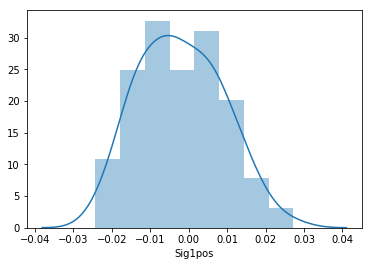

In [12]:
sns.distplot(Weight_A.iloc[0])

In [13]:
# Compare the weights for geneset B with threshold
geneSetB_ls = [l[0] for l in geneSetB.values.tolist()]
Weight_B = Weights_pos_neg_df[geneSetB_ls]

Weight_B.head()

,PA5112,PA3528,PA4610,PA1692,PA3056,PA5552,PA0999,PA4667,PA1252,PA0672,...,PA4912,PA2606,PA3887,PA2053,PA3396,PA3073,PA4330,PA2133,PA5025,PA3297
Sig1pos,-0.059506,-0.337604,-0.205478,0.087556,0.189397,-0.288102,-0.068660,-0.266719,0.103898,-0.191737,...,-0.036532,-0.100806,0.002372,-0.015176,0.028353,-0.154854,-0.016124,-0.039372,-0.147385,-0.184128
Sig1neg,-0.059506,-0.337604,-0.205478,0.087556,0.189397,-0.288102,-0.068660,-0.266719,0.103898,-0.191737,...,-0.036532,-0.100806,0.002372,-0.015176,0.028353,-0.154854,-0.016124,-0.039372,-0.147385,-0.184128
Sig2pos,-0.112592,-0.397721,-0.053481,0.043602,-0.060355,-0.194699,-0.247132,0.032952,-0.060235,0.109121,...,0.082750,-0.375723,-0.141328,0.025296,0.145418,-0.043562,0.047361,0.011333,-0.033867,-0.291762
Sig2neg,-0.112592,-0.397721,-0.053481,0.043602,-0.060355,-0.194699,-0.247132,0.032952,-0.060235,0.109121,...,0.082750,-0.375723,-0.141328,0.025296,0.145418,-0.043562,0.047361,0.011333,-0.033867,-0.291762
Sig3pos,-0.090432,-0.377118,-0.133585,0.048635,-0.069328,-0.339994,-0.097531,-0.265437,0.081696,-0.058590,...,0.029461,-0.139323,-0.062798,0.108063,0.064423,-0.096138,-0.094851,-0.051374,0.100825,-0.200890


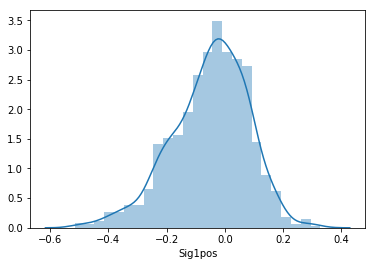

In [14]:
sns.distplot(Weight_B.iloc[0])

In [15]:
# What is the overlap between the high weight genes and gene sets A and B?
num_A = geneSetA.shape[0]
num_B = geneSetB.shape[0]

num_features_pos_neg = HW_df.shape[0]

percent_overlap = pd.DataFrame({'feature': [], 
                                'percent in A': [],
                                'percent in B': []
                               })

for i in range(num_features_pos_neg):
#for i in range(2):
    row = HW_df.iloc[i]
    percent_in_A = (row.isin(geneSetA_ls).sum()/num_A)*100
    percent_in_B = (row.isin(geneSetB_ls).sum()/num_B)*100
    
    add = pd.DataFrame({'feature': [HW_df.index[i]],
                        'percent in A': [percent_in_A],
                        'percent in B': [percent_in_B]
                       })
    percent_overlap = percent_overlap.append(add)

percent_overlap

,feature,percent in A,percent in B
0,Sig1pos,0.0,1.2
0,Sig1neg,0.0,18.6
0,Sig2pos,0.0,0.7
0,Sig2neg,0.0,18.5
0,Sig3pos,0.0,0.6
0,Sig3neg,0.0,19.6
0,Sig4pos,0.0,1.4
0,Sig4neg,0.0,14.8
0,Sig5pos,0.0,1.0
0,Sig5neg,0.0,21.2


In [16]:
# Are there any features that are nonzero?
overlap_in_A = percent_overlap.iloc[percent_overlap["percent in A"].nonzero()[0]]
overlap_in_B = percent_overlap.iloc[percent_overlap["percent in B"].nonzero()[0]]

print(overlap_in_A.shape)
print(overlap_in_B.shape)
overlap_in_A

(34, 3)
(582, 3)


,feature,percent in A,percent in B
0,Sig7neg,45.0,20.2
0,Sig12pos,18.0,7.1
0,Sig15neg,10.0,15.0
0,Sig25neg,100.0,18.7
0,Sig48neg,100.0,6.0
0,Sig56pos,100.0,0.6
0,Sig58neg,100.0,16.6
0,Sig60neg,91.0,17.1
0,Sig64neg,100.0,6.5
0,Sig65neg,100.0,18.0


In [17]:
overlap_in_B

,feature,percent in A,percent in B
0,Sig1pos,0.0,1.2
0,Sig1neg,0.0,18.6
0,Sig2pos,0.0,0.7
0,Sig2neg,0.0,18.5
0,Sig3pos,0.0,0.6
0,Sig3neg,0.0,19.6
0,Sig4pos,0.0,1.4
0,Sig4neg,0.0,14.8
0,Sig5pos,0.0,1.0
0,Sig5neg,0.0,21.2
